# Data augmentation
In this tutorial I will explore data augmentation, which is a technique to increase the diversity of a training dataset by applying random transformations. It is akin of bootstrapping. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

c:\Users\xtomma\Anaconda3\envs\machinelearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

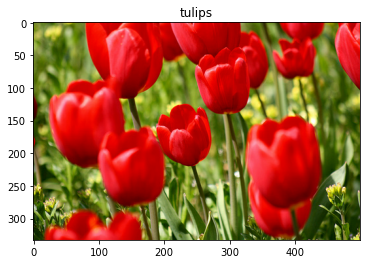

In [3]:
num_classes = metadata.features['label'].num_classes
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## Preprocessing
We want to resize images to a consistent shape, and rescale pixel values:

In [4]:
IMG_SIZE = 180
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255)
])


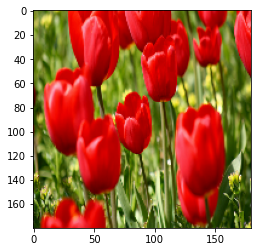

In [5]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

## Data augmentation
Let's start with the technique. We use methods such as layers.RandomFlip or layers.RandomRotation. 
Let's create a few preprocessing layers and apply them repeatedly to the same image.

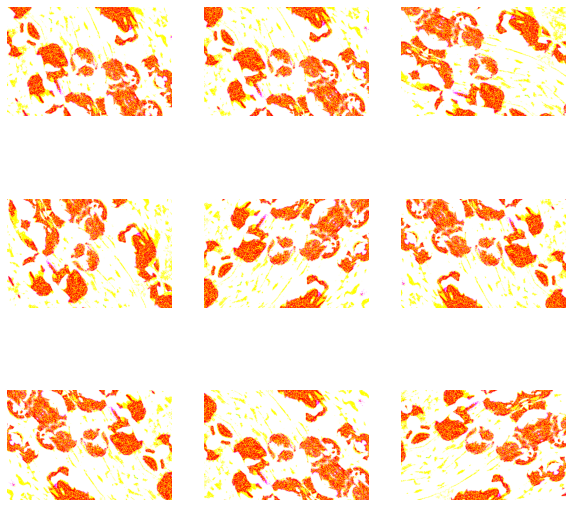

In [6]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

image = tf.cast(tf.expand_dims(image, 0), tf.float32)

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

### Options to use the Keras preprocessing layers:
1. Make the preprocessing layers part of your model
2. Apply preprocessing layers to the dataset

There are important trade-offs here. In option 1, data augmentation will run on-device, and thus it will benefit from GPU acceleration. In addition, when you export the model, the preprocessing will be saved along with the rest of the model. If the model is deployed later, it will automatically standardize images (otherwise this has to be done server side). In option 2, data augmentation will happen asynchronously, and is non-blocking. You can overlap the training of your model on the GPU with data processing, as shown below. 

We will show option 2 here.

## Apply preprocessing layers to datasets


In [7]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
                num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    ds = ds.batch(batch_size)

    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    return ds.prefetch(buffer_size=AUTOTUNE)

In [8]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

## Train a model
While the tutorial is about data augmentation, let us train the model for training. (haha)

This model has three layers of convolution and MaxPooling (is this similar to dropout but for images?), followed by a dense layer.

In [9]:
model = tf.keras.Sequential([
    layers.Conv2D(16, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 5
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
92/92 [==============================] - 110s 1s/step - loss: 1.4910 - accuracy: 0.3954 - val_loss: 1.1400 - val_accuracy: 0.5749
Epoch 2/5
92/92 [==============================] - 145s 2s/step - loss: 1.1078 - accuracy: 0.5347 - val_loss: 1.0700 - val_accuracy: 0.5722
Epoch 3/5
92/92 [==============================] - 144s 2s/step - loss: 0.9939 - accuracy: 0.6052 - val_loss: 0.9951 - val_accuracy: 0.5995
Epoch 4/5
92/92 [==============================] - 135s 1s/step - loss: 0.9682 - accuracy: 0.6148 - val_loss: 0.9484 - val_accuracy: 0.6322
Epoch 5/5
92/92 [==============================] - 137s 1s/step - loss: 0.9316 - accuracy: 0.6257 - val_loss: 0.9221 - val_accuracy: 0.6403


In [12]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

12/12 [==============================] - 3s 207ms/step - loss: 0.8390 - accuracy: 0.6676
Accuracy 0.667574942111969


### Conclusions
Data augmentation is a technique where images are enhanced in some way (flipped, change color schemes, rotated, etc) in order to increase the data available.